In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

2


In [7]:
def plot_errors(config, Nepoch):
    if "_ST_" in config.scoreNet_trained_path:
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fBiPot_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")
    else:
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fBiPot_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")

    true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
    #global_states= np.load(save_path + "_global_states.npy")/np.sqrt(config.deltaT)
    local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5) #/np.arange(1, local_states.shape[1]+1)[:, np.newaxis]
    """fig, ax = plt.subplots(2,2, figsize=(14,9))
    for dim in range(global_errors.shape[1]):
        if dim == 0: i,j = 0,0
        elif dim == 1: i,j = 0,1
        elif dim == 2: i,j = 1, 0
        else: i,j = 1,1
        ax[i,j].scatter(np.linspace(0.,deltaT*local_errors.shape[0],local_errors.shape[0]), local_errors[:, dim])
        ax[i,j].set_title(f"Score-Based Dimension {dim+1} Drift RMSE", fontsize=20)
        ax[i,j].set_xlabel("Time Axis", fontsize=20)
    plt.show()
    plt.close()"""
    fig, ax = plt.subplots(figsize=(14,9))
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
    ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
    ax.set_ylabel("RMSE", fontsize=38)
    ax.set_xlabel("Time Axis", fontsize=38)
    ax.tick_params(labelsize=38)
    plt.tight_layout()
    #if Nepoch == 1440:
        #plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/4DLnz_PM_LSTM_{Nepoch}Nep.png",  bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at Nepoch {epoch}\n")


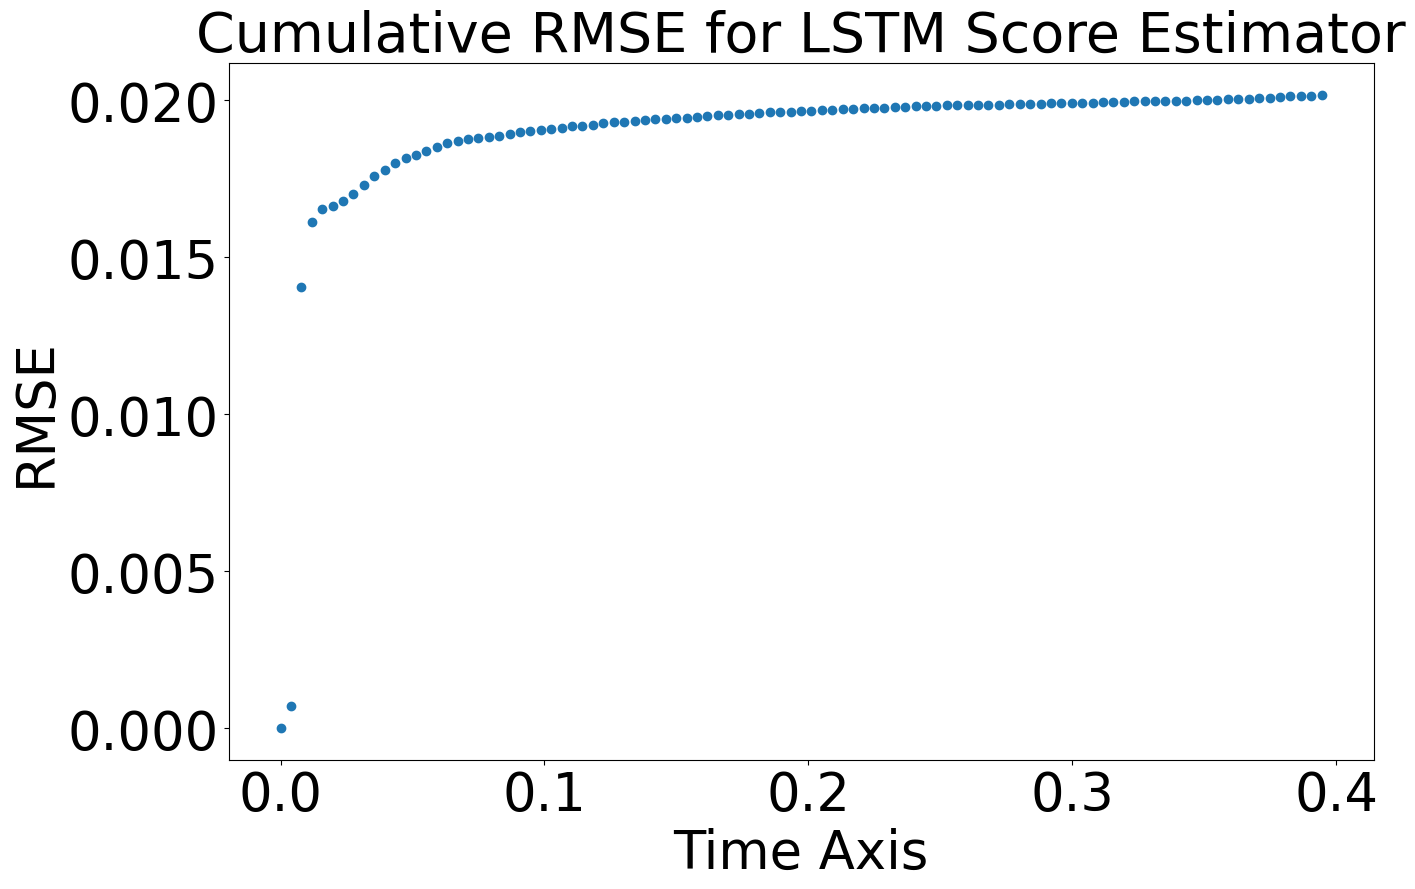

Final time cumulative RMSE local-time error 0.02018050760226663 at Nepoch 150



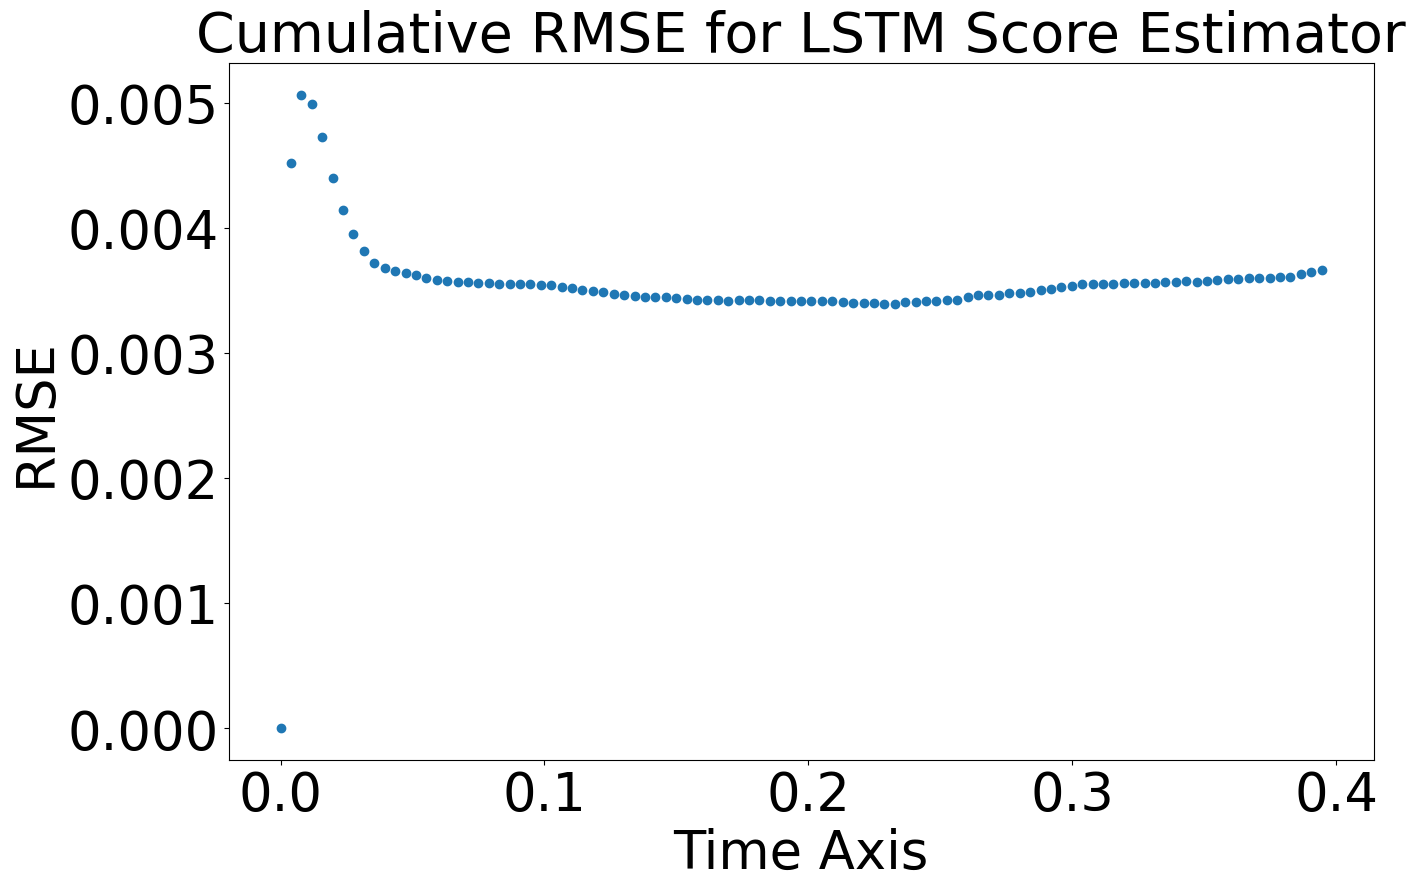

Final time cumulative RMSE local-time error 0.00366378771269939 at Nepoch 300



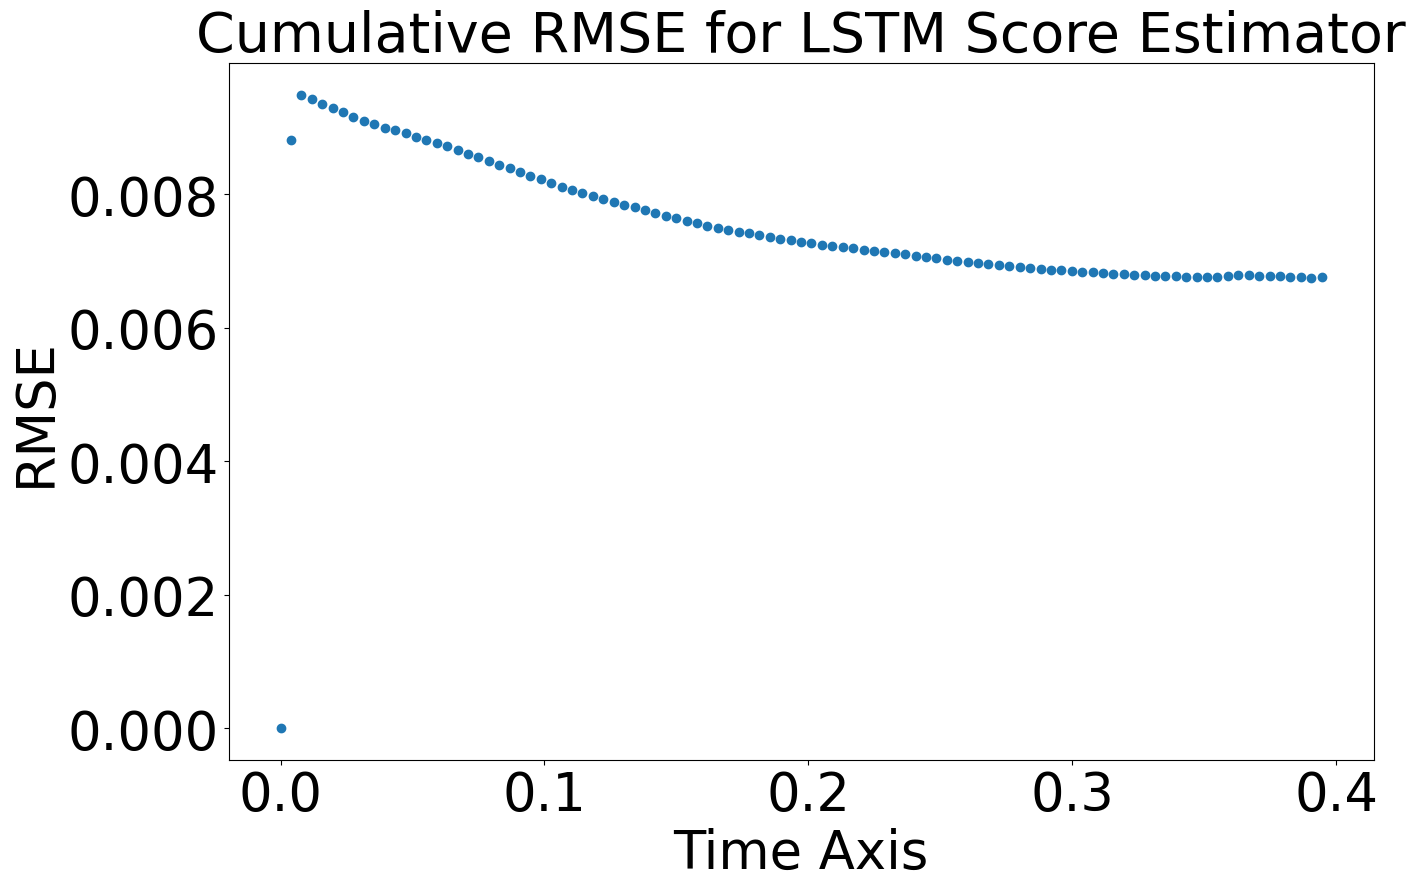

Final time cumulative RMSE local-time error 0.006760708335547588 at Nepoch 960



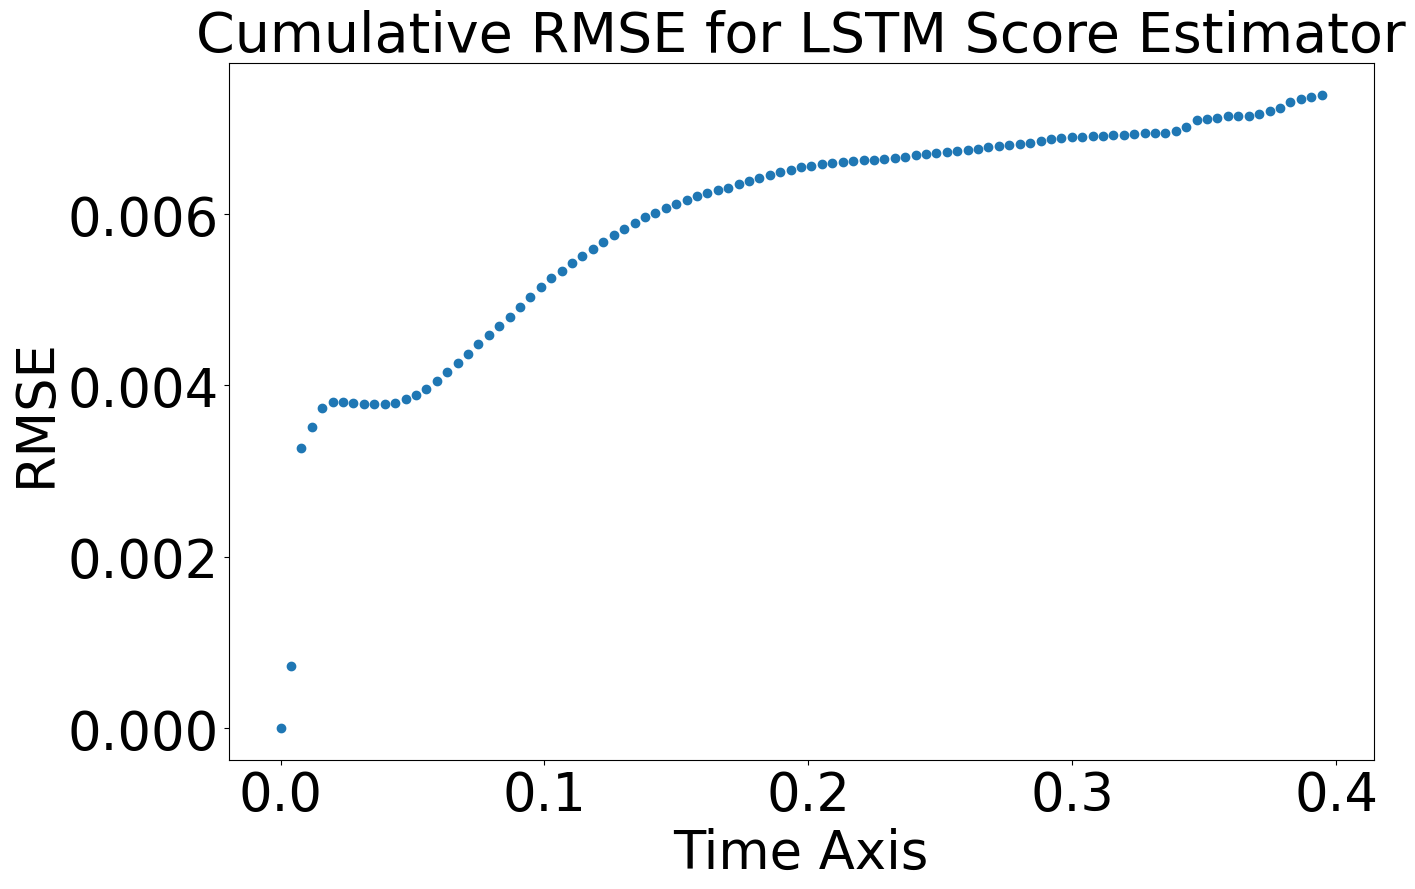

Final time cumulative RMSE local-time error 0.007393776170717708 at Nepoch 1440



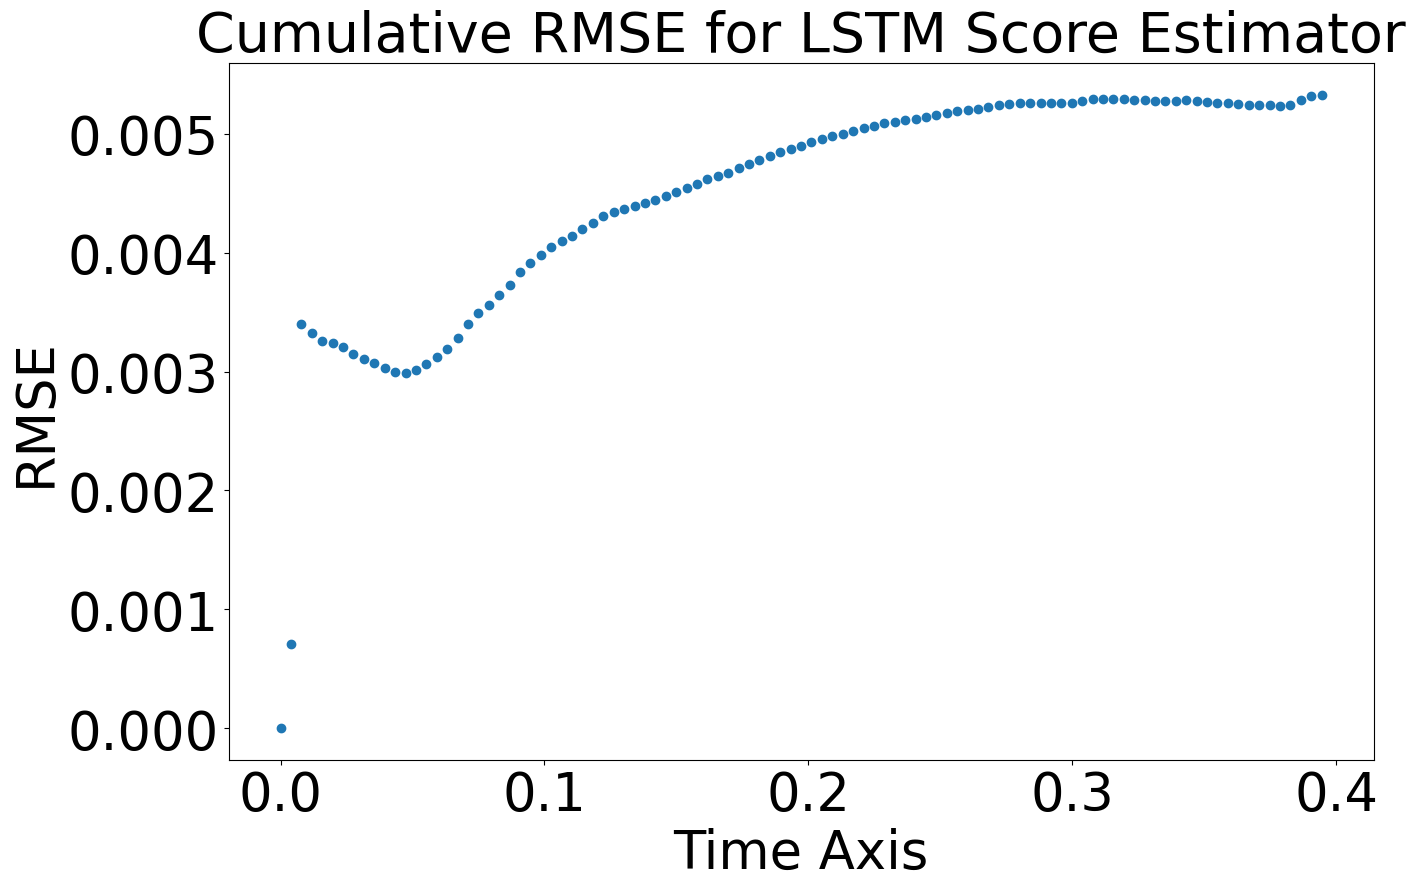

Final time cumulative RMSE local-time error 0.0053293836793296984 at Nepoch 1920



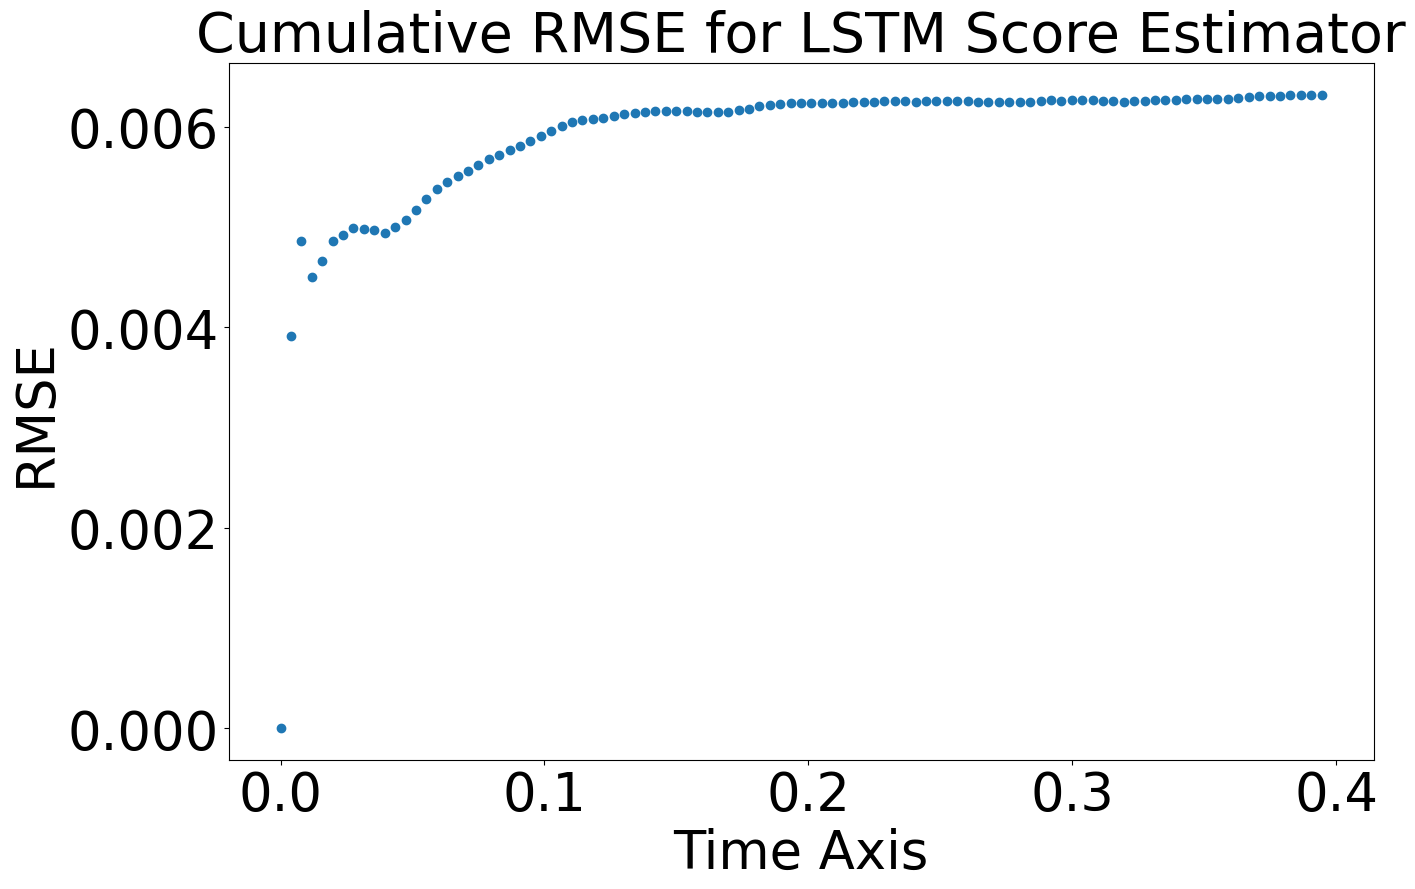

Final time cumulative RMSE local-time error 0.0063192406248111285 at Nepoch 2920



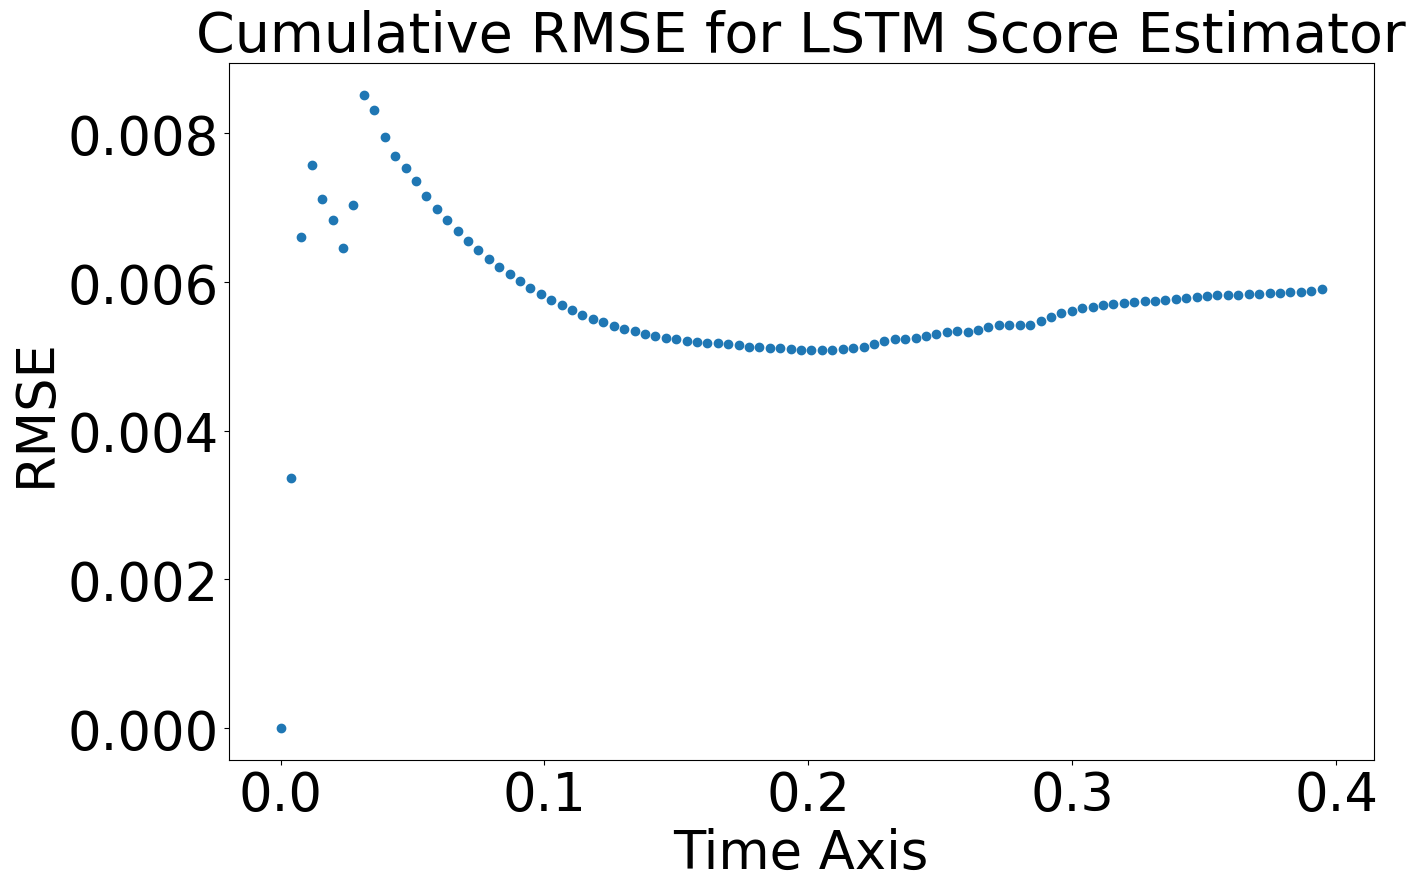

Final time cumulative RMSE local-time error 0.005900957562603511 at Nepoch 6920



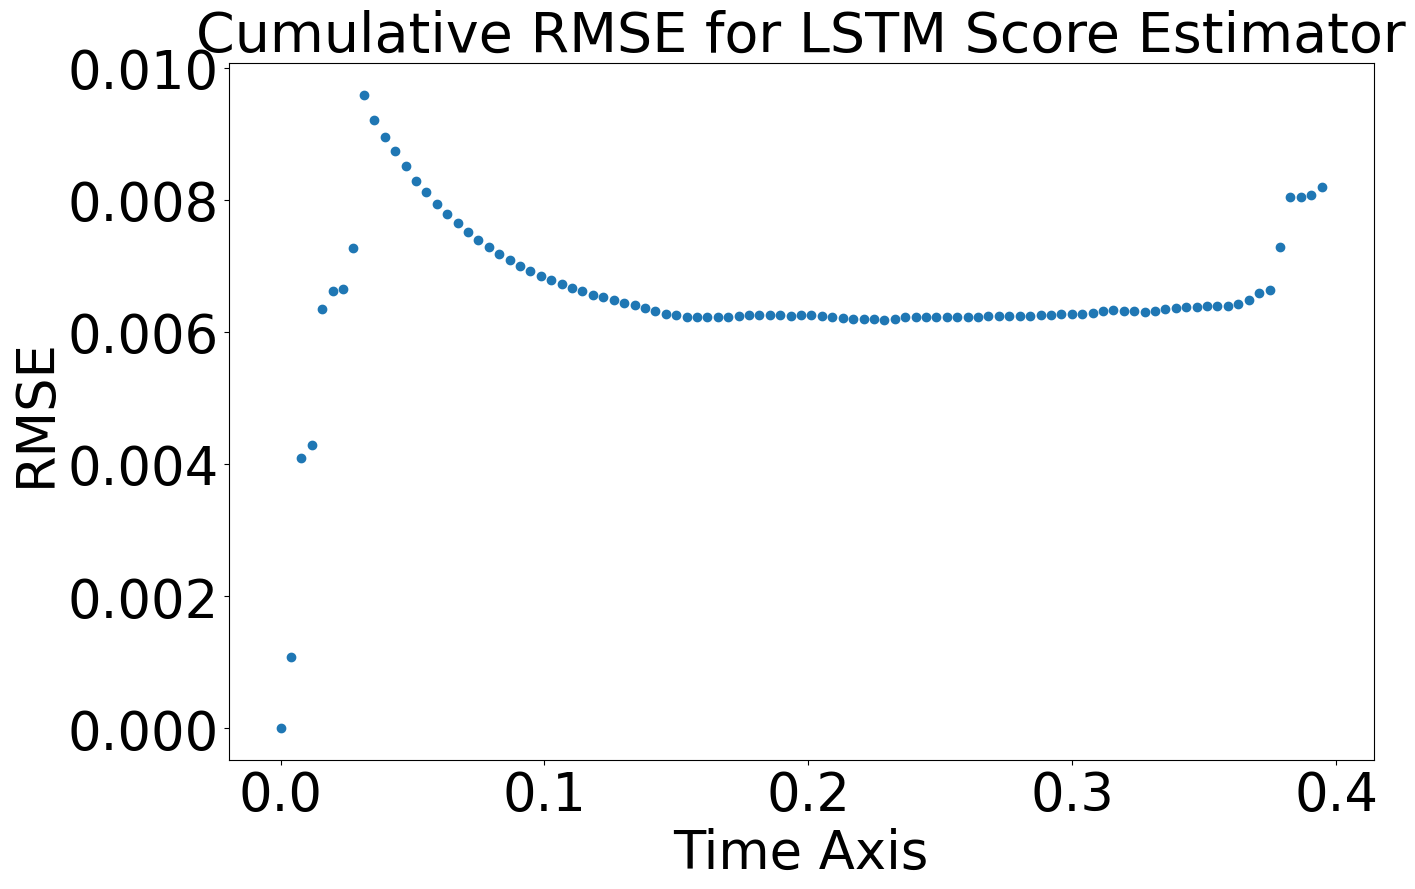

Final time cumulative RMSE local-time error 0.008198015614365046 at Nepoch 7190



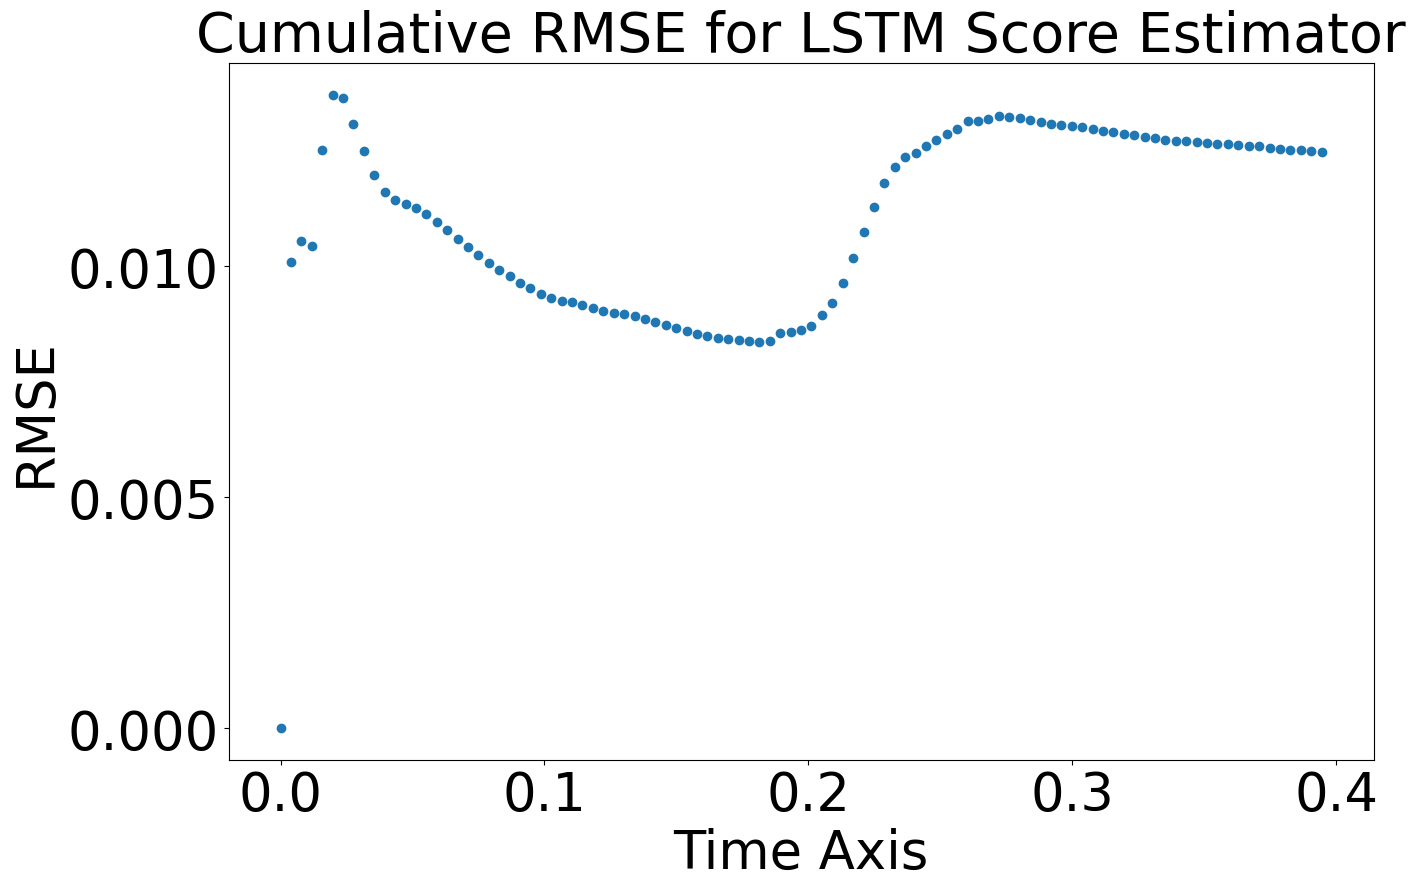

Final time cumulative RMSE local-time error 0.012481863064602423 at Nepoch 8190



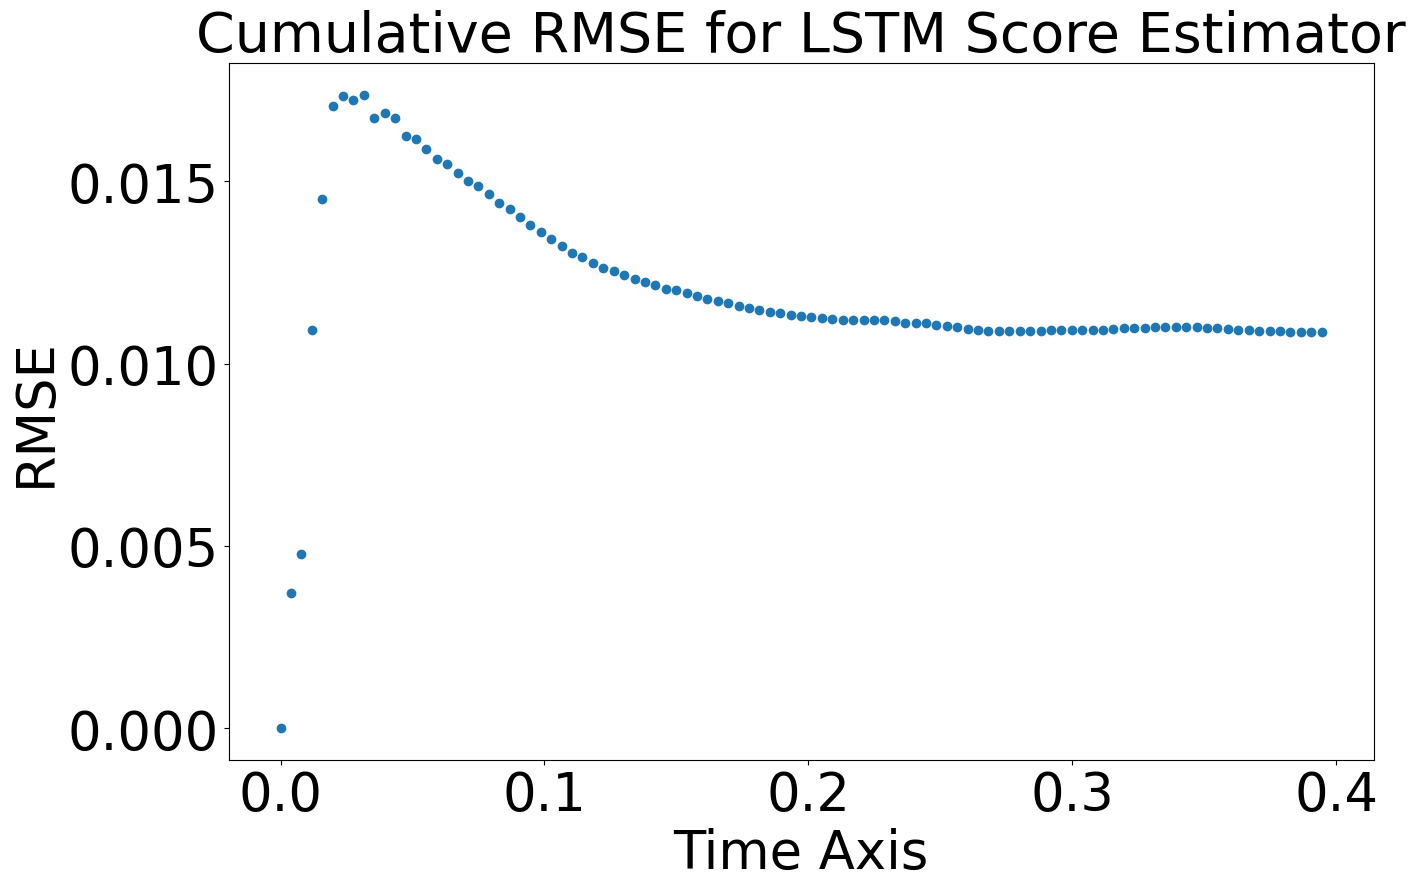

Final time cumulative RMSE local-time error 0.010863041141303155 at Nepoch 12920



In [8]:
for epoch in config.max_epochs:
    try:
        plot_errors(config=config, Nepoch=epoch)
    except FileNotFoundError:
        continue